# References:
1. Deep Learning for Predictive Maintenance https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb

2. Predictive Maintenance: Step 2A of 3, train and evaluate regression models https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2

3. A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), NASA Ames Research Center, Moffett Field, CA

4. Understanding LSTM Networks http://colah.github.io/posts/2015-08-Understanding-LSTMs/

This notebook was forked from https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM

In [1]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = './Output/regression_model.h5'

##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('./Dataset/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('./Dataset/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('./Dataset/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
##################################
# Prepare training data
##################################

# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#train_df.to_csv('../../Dataset/PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)


In [3]:
##################################
# Prepare test data
##################################

# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('../../Dataset/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)

# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


   id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154  0.408001   
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082  0.332039   

    s5     ...           s13       s14       s15  s16       s17  s18  s19  \
0  0.0     ...      0.220588  0.132160  0.308965  0.0  0.333333  0.0  0.0   
1  0.0     ...      0.264706  0.204768  0.213159  0.0  0.416667  0.0  0.0   
2  0.0     ...      0.220588  0.155640  0.458638  0.0  0.416667  0.0  0.0   
3  0.0     ...      0.250000  0.170090  0.257022  0.0  0.250000  0.0  0.0   
4  0.0     ...      0.220588  0.152751  0.300885  0.0  0.166667  0.0  0.0   

        s20       s21  cycle_norm  
0  0.558140  0

(15631, 1)

In [4]:
##################################
# Modeling
##################################

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [7]:
# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=5, batch_size=10, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None
T

In [8]:
# Save the training history
import pickle
filename = open("./Output/rul_point_regression_model_history","wb")
pickle.dump(history.history, filename)
filename.close()
        
history_file = open('./Output/rul_point_regression_model_history','rb')
saved_history = pickle.load(history_file)
history_file.close()

In [9]:
# Save model to disk
# serialize model to JSON
model_json = model.to_json()
with open("./Output/rul_point_regression_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./Output/rul_point_regression_model.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
###########################################
# Load model and training history from disk
###########################################
import pickle
history_file = open("./Output/rul_point_regression_model_history","rb")
saved_history = pickle.load(history_file)
history_file.close()

# Load model from disk
from keras.models import model_from_json
# load json and create model
json_file = open("./Output/rul_point_regression_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./Output/rul_point_regression_model.h5")
print("Loaded model from disk")

Loaded model from disk


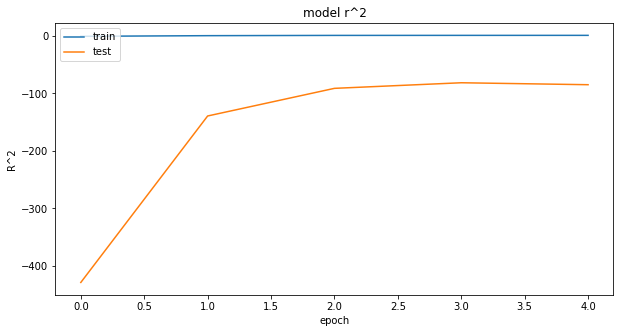

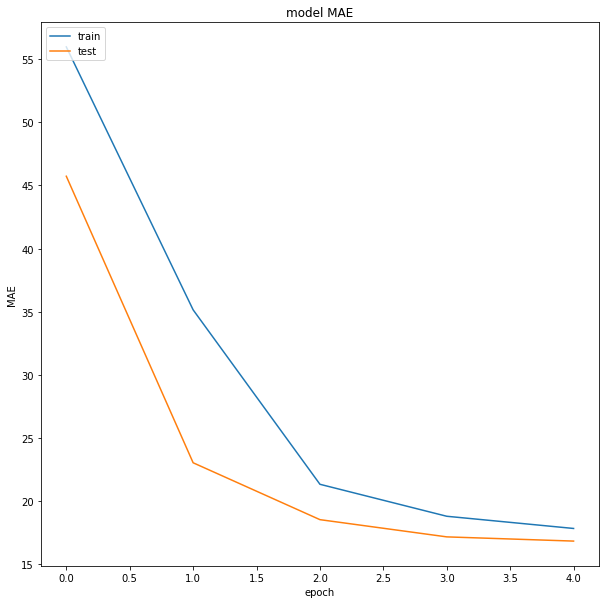

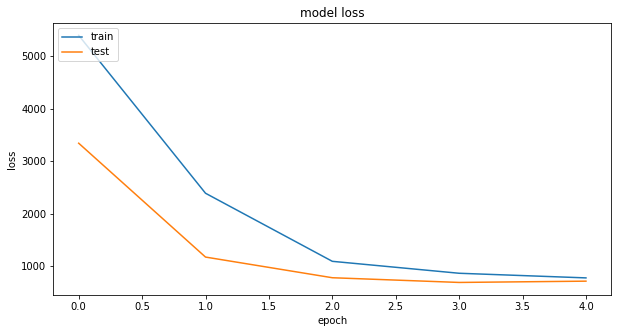

15631/15631 [==============================] - 6s 395us/step

MAE: 17.071733885378507

R^2: 0.723271380801796
15631/15631 [==============================] - 7s 464us/step


In [11]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 5))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_regression_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('./Output/submit_train.csv', index = None)

In [34]:
truth_df = pd.read_csv('./Dataset/CMAPSSData/RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

test_df = pd.read_csv('./Dataset/CMAPSSData/test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2


   id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154  0.408001   
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082  0.332039   

    s5     ...           s13       s14       s15  s16       s17  s18  s19  \
0  0.0     ...      0.220588  0.132160  0.308965  0.0  0.333333  0.0  0.0   
1  0.0     ...      0.264706  0.204768  0.213159  0.0  0.416667  0.0  0.0   
2  0.0     ...      0.220588  0.155640  0.458638  0.0  0.416667  0.0  0.0   
3  0.0     ...      0.250000  0.170090  0.257022  0.0  0.250000  0.0  0.0   
4  0.0     ...      0.220588  0.152751  0.300885  0.0  0.166667  0.0  0.0   

        s20       s21  cycle_norm  
0  0.558140  0

seq_array_test_last
(93, 50, 25)
(93, 1)
label_array_test_last
[[ 69.]
 [ 82.]
 [ 91.]
 [ 93.]
 [ 91.]
 [ 95.]
 [111.]
 [ 96.]
 [ 97.]
 [124.]
 [ 95.]
 [ 83.]
 [ 84.]
 [ 50.]
 [ 28.]
 [ 87.]
 [ 16.]
 [ 57.]
 [113.]
 [ 20.]
 [119.]
 [ 66.]
 [ 97.]
 [ 90.]
 [115.]
 [  8.]
 [ 48.]
 [106.]
 [  7.]
 [ 11.]
 [ 19.]
 [ 21.]
 [ 50.]
 [ 28.]
 [ 18.]
 [ 10.]
 [ 59.]
 [109.]
 [114.]
 [ 47.]
 [135.]
 [ 92.]
 [ 21.]
 [ 79.]
 [114.]
 [ 29.]
 [ 26.]
 [ 97.]
 [137.]
 [ 15.]
 [103.]
 [ 37.]
 [114.]
 [100.]
 [ 21.]
 [ 54.]
 [ 72.]
 [ 28.]
 [128.]
 [ 14.]
 [ 77.]
 [  8.]
 [121.]
 [ 94.]
 [118.]
 [ 50.]
 [131.]
 [126.]
 [113.]
 [ 10.]
 [ 34.]
 [107.]
 [ 63.]
 [ 90.]
 [  8.]
 [  9.]
 [137.]
 [ 58.]
 [ 89.]
 [116.]
 [115.]
 [136.]
 [ 28.]
 [ 38.]
 [ 20.]
 [ 85.]
 [ 55.]
 [128.]
 [137.]
 [ 82.]
 [ 59.]
 [117.]
 [ 20.]]

MAE: 13.347691043730705

R^2: 0.7767043587982013


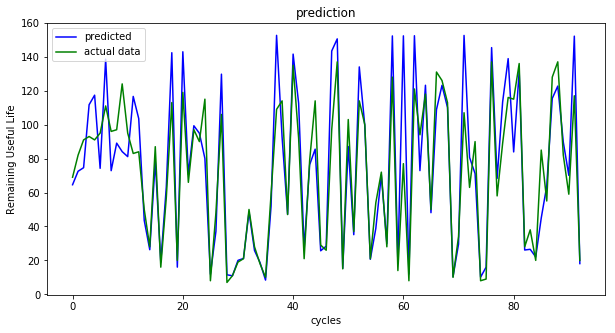

In [12]:
##################################
# EVALUATE ON TEST DATA
##################################

# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
#print(seq_array_test_last)
print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('./Output/submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('Remaining Useful Life')
    plt.xlabel('cycles')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("./Output/model_regression_verify.png")